## Web Crawing
- 웹 페이지에서 데이터를 수집하는 방법에 대해서 학습

### 웹크롤링 방법

#### 웹페이지의 종류
- 정적인 페이지 : 웹 브라우져에 화면이 한번 뜨면 이벤트에 의한 화면의 변경이 없는 페이지 
- 동적인 페이지 : 웹 브라우져에 화면이 뜨고 이벤트가 발생하면 서버에서 데이터를 가져와 화면을 변경하는 페이지

#### requests 이용
- 받아오는 문자열에 따라 두가지 방법으로 구분
    - json 문자열로 받아서 파싱하는 방법 : 주로 동적 페이지 크롤링할때 사용 
    - html 문자열로 받아서 파싱하는 방법 : 주로 정적 페이지 크롤링할때 사용
        
#### selenium 이용
- 브라우져를 직접 열어서 데이터를 받는 방법

#### 크롤링 방법에 따른 속도
- requests json > requests html > selenium

### Crwaling Naver Stock Datas
- 네이버 증권 사이트에서 주가 데이터 수집
- 수집할 데이터 : 일별 kospi, kosdaq 주가, 일별 환율(exchange rate) 데이터
- 데이터 수집 절차
    - 웹서비스 분석 : 크롬의 개발자 도구를 통해 url 탐색
    - 서버에 데이터 요청 : request(url) > response : json(str)
    - 서버에서 받은 데이터 파싱(데이터 형태를 변경) : json(str) > list, dict > DataFrame

In [1]:
import warnings
warnings.filterwarnings('ignore')
import requests as rq
import pandas as pd

#### 1. 웹서비스 분석 : url
- pc 웹페이지가 복잡하면 mobile 웹페이지에서 수집

In [3]:
page, pageSize = 1, 20
url = f'https://m.stock.naver.com/api/stocks/marketValue/KOSPI?page={page}&pageSize={pageSize}'
print(url)

https://m.stock.naver.com/api/stocks/marketValue/KOSPI?page=1&pageSize=20


#### 2. 서버에 데이터 요청 : request(url) > response : json(str)
- response의 status code가 200이 나오는지 확인
- 403이나 500이 나오면 request가 잘못되거나 web server에서 수집이 안되도록 설정이 된것임
    - header 설정 또는 selenium 사용
- 200이 나오더라도 response 안에 있는 내용을 확인 > 확인하는 방법 : response.text

In [5]:
response = rq.get(url)
response

<Response [200]>

#### 3. 서버에서 받은 데이터 파싱(데이터 형태를 변경) : json(str) > list, dict > DataFrame

In [ ]:
data = response.json()
data

In [14]:
kospi = pd.DataFrame(data)
kospi.head()

,stockListSortType,stockListCategoryType,stocks,totalCount,page,pageSize,localOpenTimeDesc,marketStatus
18,MARKET_VALUE,KOSPI,"{'stockType': 'domestic', 'stockEndType': 'sto...",2091,1,20,오전 9시에 주식시장이 시작될 예정입니다.,OPEN
19,MARKET_VALUE,KOSPI,"{'stockType': 'domestic', 'stockEndType': 'sto...",2091,1,20,오전 9시에 주식시장이 시작될 예정입니다.,OPEN


#### 4. 함수로 만들기

In [65]:
def stock_crawling(code, page, pagesize):
    url = f'https://m.stock.naver.com/api/index/{code}/price?pageSize={pagesize}&page={page}' 
    response = rq.get(url)
    return pd.DataFrame(response.json())[['localTradedAt', 'closePrice']]

In [66]:
kospi_df = stock_crawling('KOSPI', 1, 60)
display(kospi_df.head(2))
display(kospi_df.tail(2))

,localTradedAt,closePrice
0,2023-08-24,"2,533.00"
1,2023-08-23,"2,505.50"


,localTradedAt,closePrice
58,2023-06-01,"2,569.17"
59,2023-05-31,"2,577.12"


In [67]:
kosdaq_df = stock_crawling('KOSDAQ', 1, 60)
display(kosdaq_df.head(2))
display(kosdaq_df.tail(2))

,localTradedAt,closePrice
0,2023-08-24,900.24
1,2023-08-23,882.87


,localTradedAt,closePrice
58,2023-06-01,863.78
59,2023-05-31,856.94


#### 5. 원달러 환율 데이터 수집 : 실습

In [68]:
# 1. json 요청 url 찾아내기
# 2. request 해서 response 받아오기
# 3. json으로 바꿔서 DataFrame으로 바꾸기
def exchange_crawling(page, pageSize):
    url = f'https://m.stock.naver.com/front-api/v1/marketIndex/prices?page={page}&category=exchange&reutersCode=FX_USDKRW&pageSize={pageSize}'
    response = rq.get(url)
    data = response.json()['result']
    return pd.DataFrame(data)[['localTradedAt', 'closePrice']]

In [69]:
usd_df = exchange_crawling(1, 60)
display(usd_df.head(2))
display(usd_df.tail(2))

,localTradedAt,closePrice
0,2023-08-24,"1,321.20"
1,2023-08-23,"1,335.00"


,localTradedAt,closePrice
58,2023-06-01,"1,320.00"
59,2023-05-31,"1,328.00"


#### 6. 시각화

In [64]:
# 전처리 : date, kospiu, kosdaq, usd 컬럼이 있는 데이터프레임으로 변경
df = kospi_df.copy()
df.columns = ['date', 'kospi']
df.head()

,date,kospi
0,2023-08-24,"2,531.20"
1,2023-08-23,"2,505.50"
2,2023-08-22,"2,515.74"
3,2023-08-21,"2,508.80"
4,2023-08-18,"2,504.50"


In [72]:
df['kosdaq'] = kosdaq_df['closePrice']
df['usd'] = usd_df['closePrice']
df.head()

,date,kospi,kosdaq,usd
0,2023-08-24,"2,531.20",900.24,"1,321.20"
1,2023-08-23,"2,505.50",882.87,"1,335.00"
2,2023-08-22,"2,515.74",893.33,"1,339.50"
3,2023-08-21,"2,508.80",888.71,"1,341.00"
4,2023-08-18,"2,504.50",877.32,"1,343.00"


In [71]:
df.dtypes

date      object
kospi     object
kosdaq    object
usd       object
dtype: object

In [73]:
df['kospi'] = df['kospi'].apply(lambda data: data.replace(',', ''))
df['kosdaq'] = df['kosdaq'].apply(lambda data: data.replace(',', ''))
df['usd'] = df['usd'].apply(lambda data: data.replace(',', ''))
df.head()

,date,kospi,kosdaq,usd
0,2023-08-24,2531.20,900.24,1321.20
1,2023-08-23,2505.50,882.87,1335.00
2,2023-08-22,2515.74,893.33,1339.50
3,2023-08-21,2508.80,888.71,1341.00
4,2023-08-18,2504.50,877.32,1343.00


In [76]:
df['kospi'] = df['kospi'].astype('float')
df['kosdaq'] = df['kosdaq'].astype('float')
df['usd'] = df['usd'].astype('float')
print(df.dtypes)
print()
display(df.head())

date       object
kospi     float64
kosdaq    float64
usd       float64
dtype: object



,date,kospi,kosdaq,usd
0,2023-08-24,2531.20,900.24,1321.2
1,2023-08-23,2505.50,882.87,1335.0
2,2023-08-22,2515.74,893.33,1339.5
3,2023-08-21,2508.80,888.71,1341.0
4,2023-08-18,2504.50,877.32,1343.0


In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

In [82]:
%config InlineBackend.figure_formats = {'png', 'retina'}

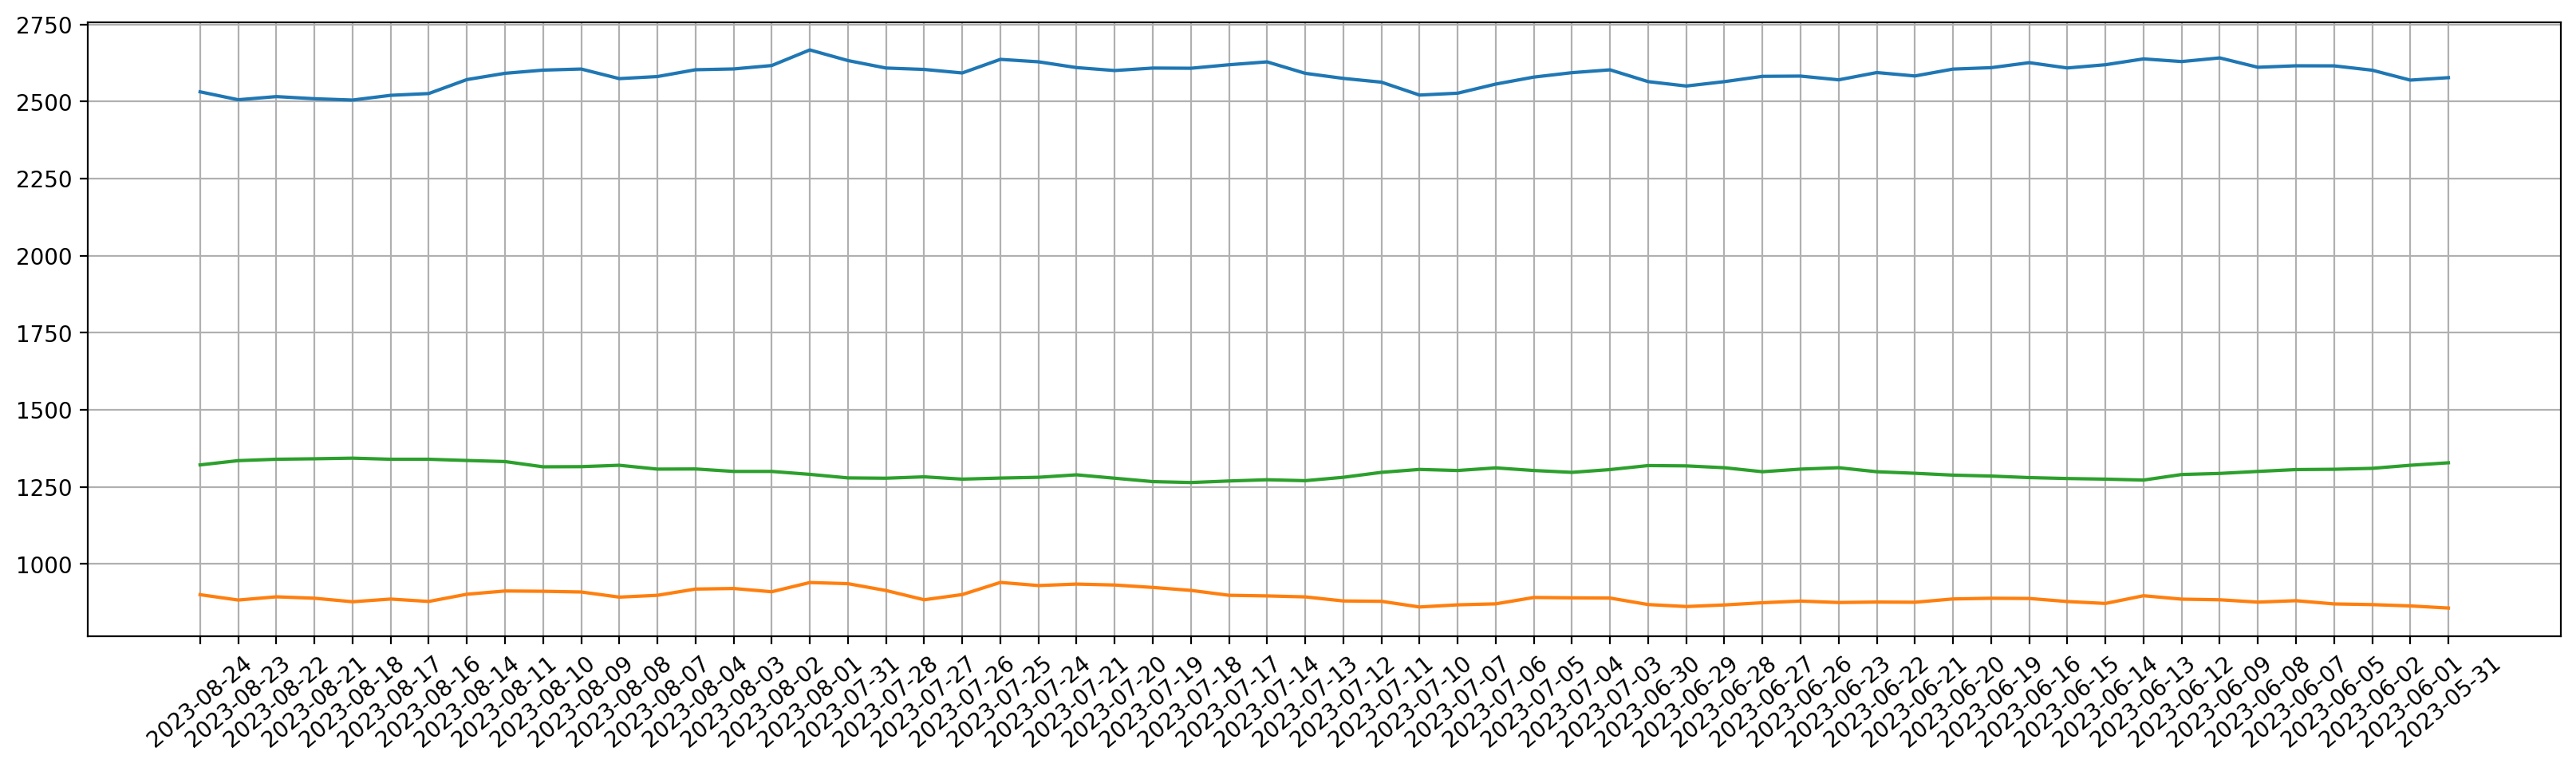

In [83]:
plt.figure(figsize=(20,5))

plt.plot('date', 'kospi', data = df)
plt.plot('date', 'kosdaq', data = df)
plt.plot('date', 'usd', data = df)

plt.xticks(rotation = 40)
plt.grid()
plt.show()

#### 7. 데이터 스케일링
- min max scaling


- $z = \frac{x_i - min(x)}{max(x) - min(x)} (0 \leqq z \leqq 1)$


- latex syntax : `https://jjycjnmath.tistory.com/117`

In [84]:
from sklearn.preprocessing import minmax_scale

In [85]:
minmax_scale(df['kospi'])

array([0.16423694, 0.0061512 , 0.06913945, 0.02645014, 0.        ,
       0.09442086, 0.13003629, 0.40825491, 0.5336778 , 0.59703512,
       0.61893338, 0.42738513, 0.46878268, 0.60466261, 0.62059421,
       0.68874946, 1.        , 0.78784524, 0.63861721, 0.61087532,
       0.54044412, 0.81171188, 0.76293289, 0.64747493, 0.58885403,
       0.63812512, 0.63431137, 0.70431199, 0.76151812, 0.53349326,
       0.43193701, 0.35670788, 0.09964938, 0.13661807, 0.31857046,
       0.45826413, 0.54628775, 0.60263271, 0.36771852, 0.28000246,
       0.36716491, 0.47296549, 0.47794796, 0.40351848, 0.54868672,
       0.48059298, 0.61764163, 0.64587562, 0.74607861, 0.63997047,
       0.70480408, 0.82087716, 0.76797687, 0.8406225 , 0.65417974,
       0.68339792, 0.68222919, 0.59580488, 0.39779787, 0.44669988])

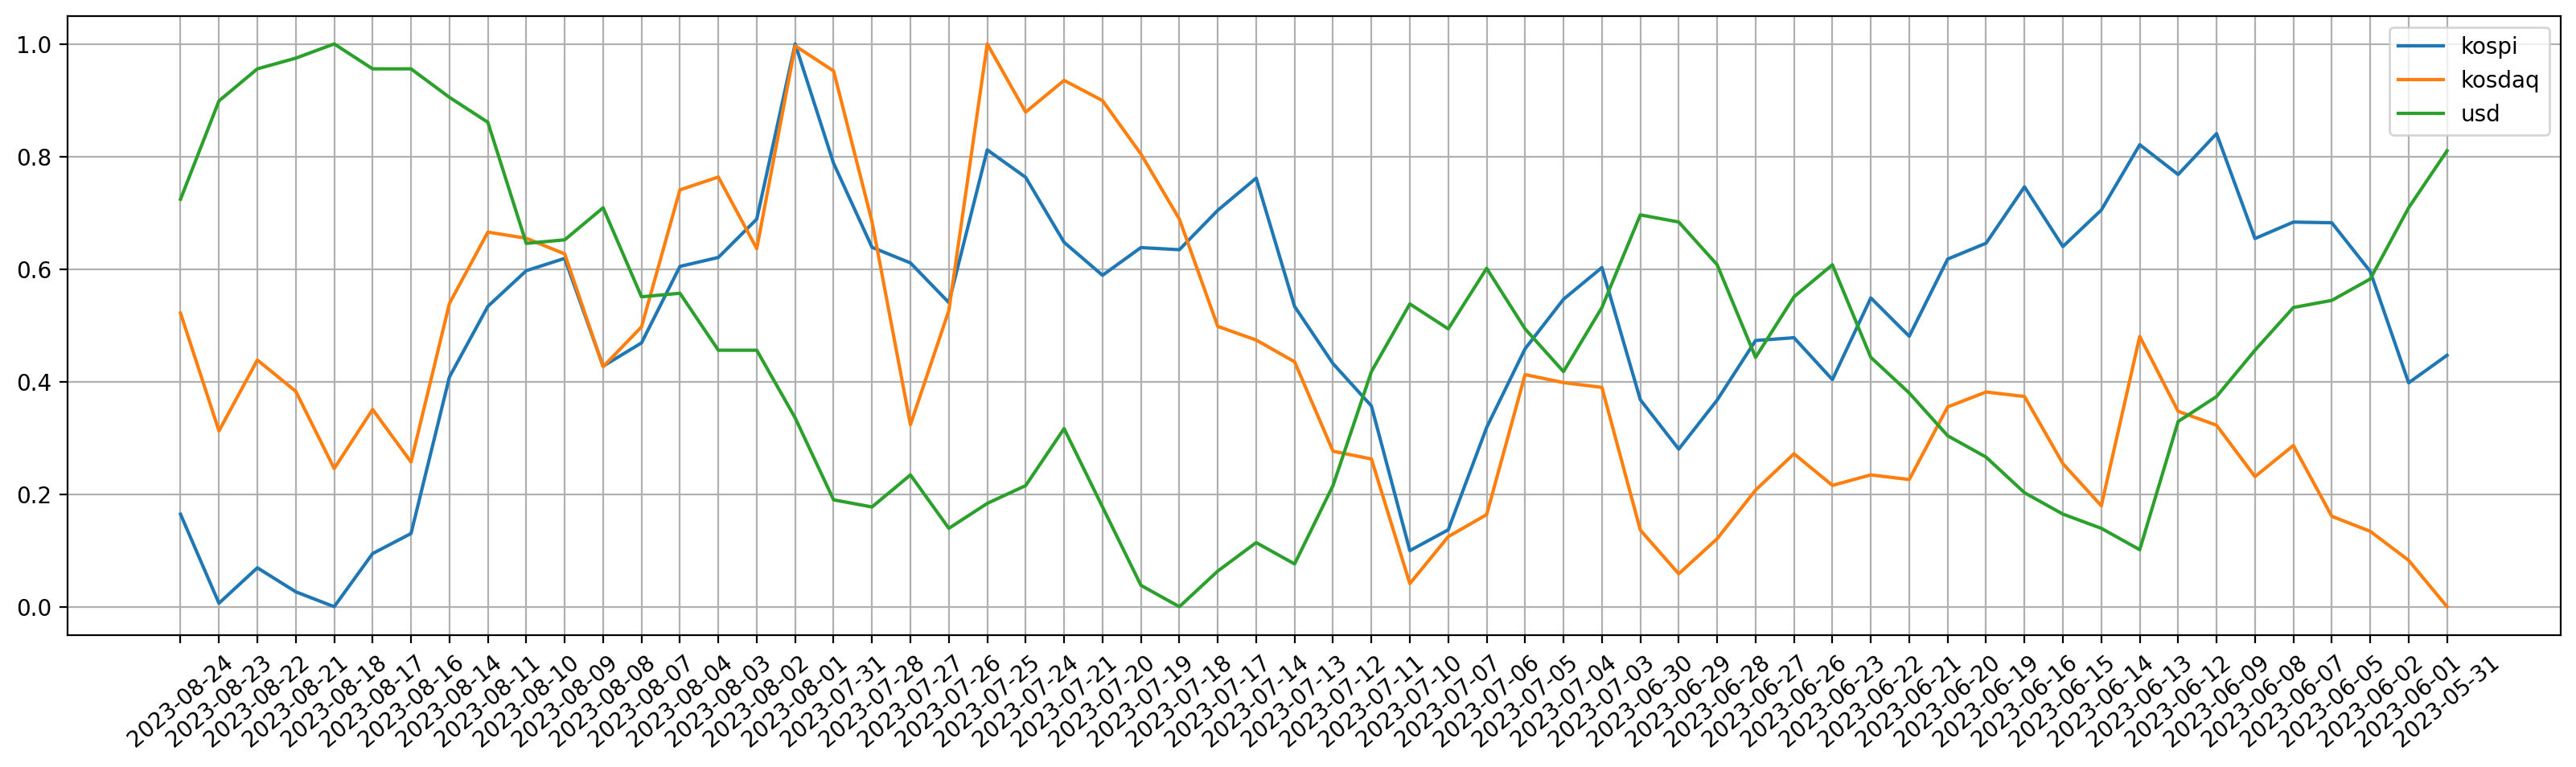

In [88]:
plt.figure(figsize=(20,5))

plt.plot(df['date'], minmax_scale(df['kospi']), label='kospi')
plt.plot(df['date'], minmax_scale(df['kosdaq']), label='kosdaq')
plt.plot(df['date'], minmax_scale(df['usd']), label='usd')

plt.legend(loc = 'upper right')
plt.xticks(rotation = 40)
plt.grid()
plt.show()

#### 8. 상관관계 분석
- 피어슨 상관계수(Pearson Correlation Coefficient)
- 두 데이터 집합의 상관도를 분석할때 사용되는 지표
- 상관계수의 해석
    - -1에 가까울수록 서로 반대방향으로 움직임
    - 1에 가까울수록 서로 같은방향으로 움직임
    - 0에 가까울수록 두 데이터는 관계가 없음

In [87]:
df.corr()

,kospi,kosdaq,usd
kospi,1.000000,0.478920,-0.727651
kosdaq,0.478920,1.000000,-0.358302
usd,-0.727651,-0.358302,1.000000


In [90]:
import scipy.stats as spst

In [91]:
spst.pearsonr(df['kospi'], df['usd'])

(-0.727650686035538, 4.5195799944206514e-11)

In [ ]:
# 데이터 분석 : 코스피/코스닥/원달러환율의 상관분석
# 가설 : 코스피가 높으면 원달러 환율은 낮고, 코스피가 낮으면 원달러 환율은 높다.
# 상관계수를 보았을 때 유의미한 상관계수를 가지며, p-value 또한 0에 가깝기 때문에 대립가설을 채택할 수 있다.